In [3]:
import os.path

from torch.utils.data import TensorDataset

from evaluation import visualize_results
from load_neural_net import load_models
from settings import FEATURES, BASE_DIR

model_dir = os.path.join(BASE_DIR, "best_models", "neural_net")
models = load_models(input_dim=len(FEATURES), base_dir=model_dir)
models


[Net(
   (net): Sequential(
     (0): Linear(in_features=5, out_features=512, bias=True)
     (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.2, inplace=False)
     (4): Linear(in_features=512, out_features=256, bias=True)
     (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): ReLU()
     (7): Dropout(p=0.3, inplace=False)
     (8): Linear(in_features=256, out_features=128, bias=True)
     (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (10): ReLU()
     (11): Dropout(p=0.2, inplace=False)
     (12): Linear(in_features=128, out_features=64, bias=True)
     (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (14): ReLU()
     (15): Dropout(p=0.1, inplace=False)
     (16): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 Net(
   (net): Sequential(
     (0): Linear(in_features

In [4]:
import pandas as pd
test_path = os.path.join(BASE_DIR, "dataset", "test.csv")
test_df = pd.read_csv(test_path)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   genres           200 non-null    object 
 1   rating           200 non-null    float64
 2   no_of_votes      200 non-null    int64  
 3   meta_score       200 non-null    float64
 4   release_date     200 non-null    float64
 5   gross            200 non-null    float64
 6   budget           200 non-null    float64
 7   countries        200 non-null    object 
 8   log_budget       200 non-null    float64
 9   log_no_of_votes  200 non-null    float64
 10  log_gross        200 non-null    float64
 11  log_gross_bin    200 non-null    int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 18.9+ KB


Fold 1


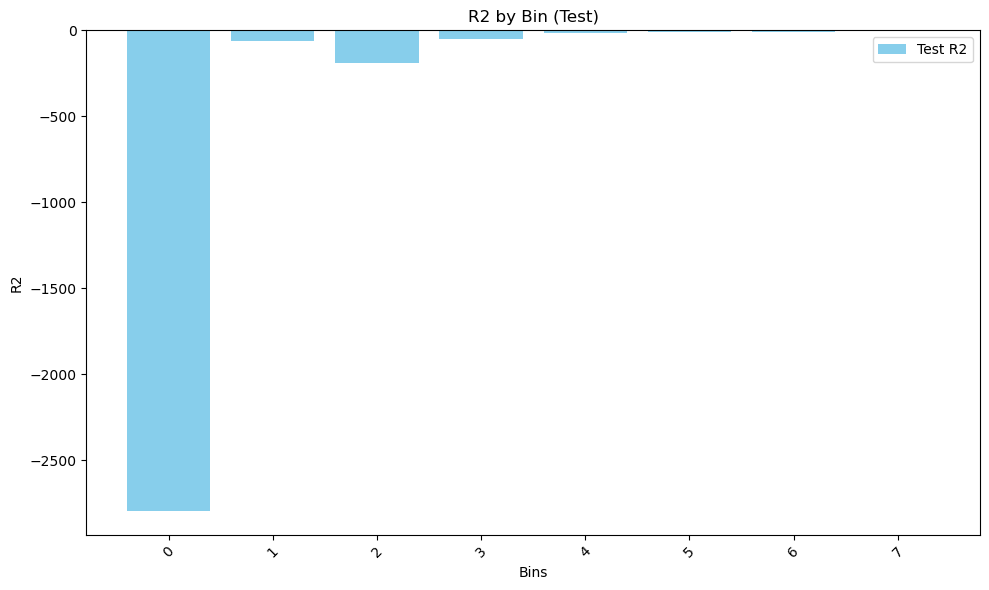

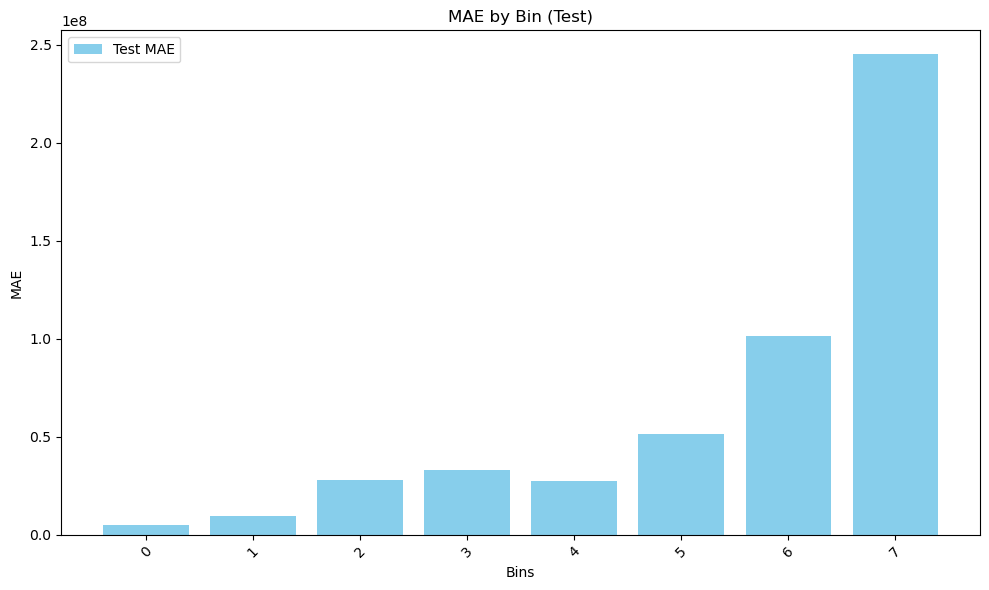

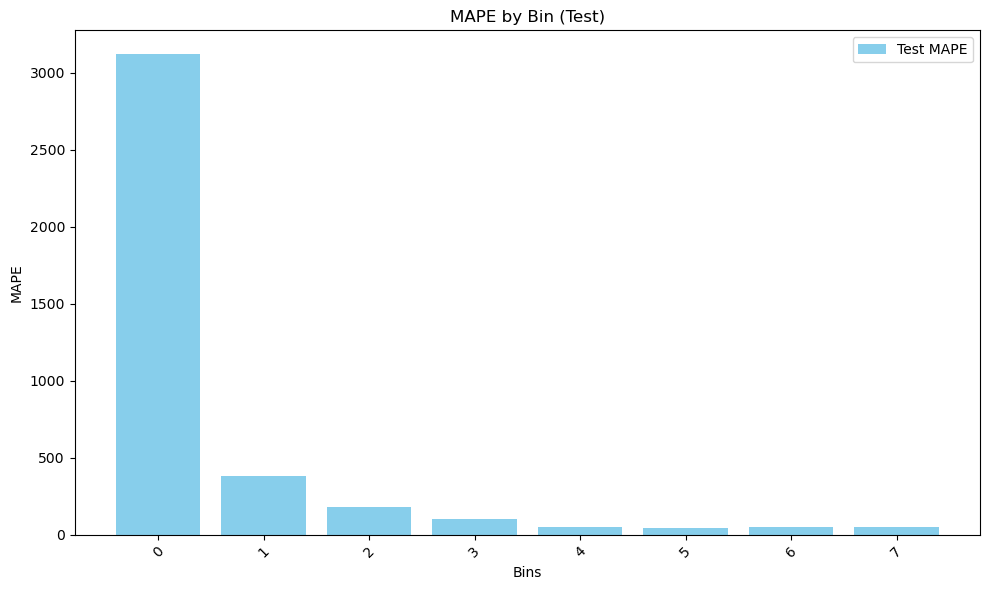

Fold 2


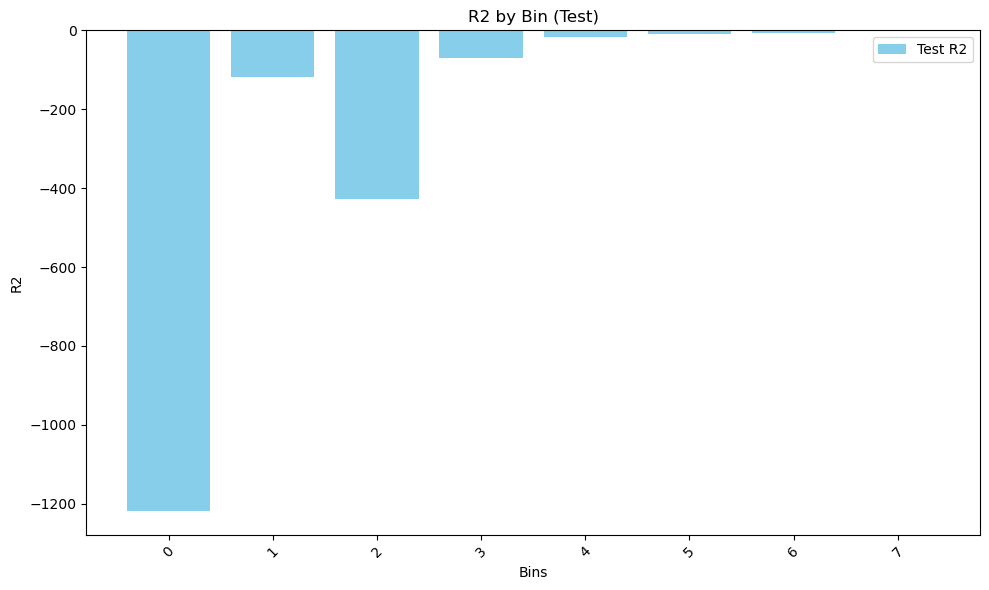

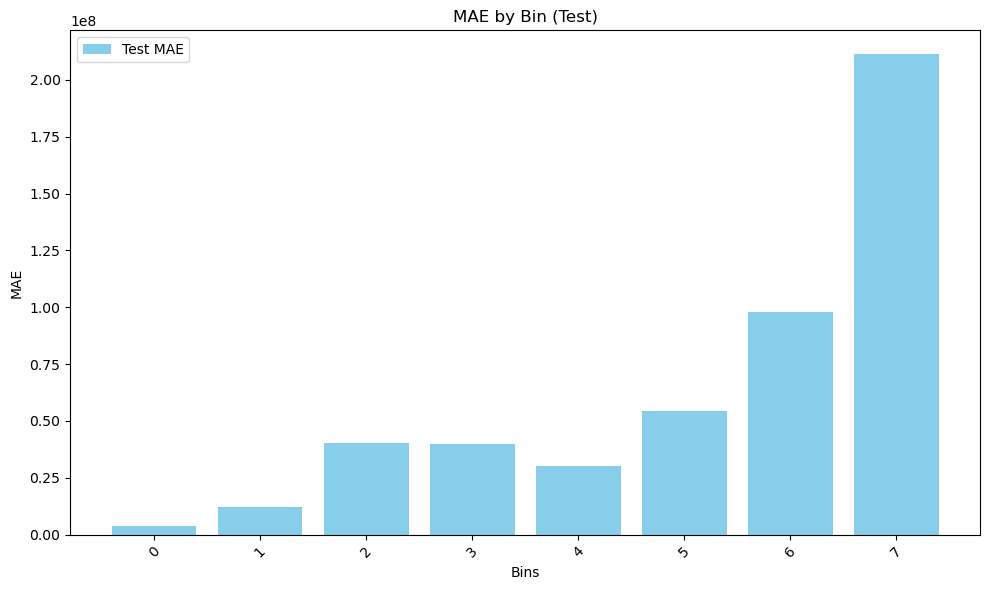

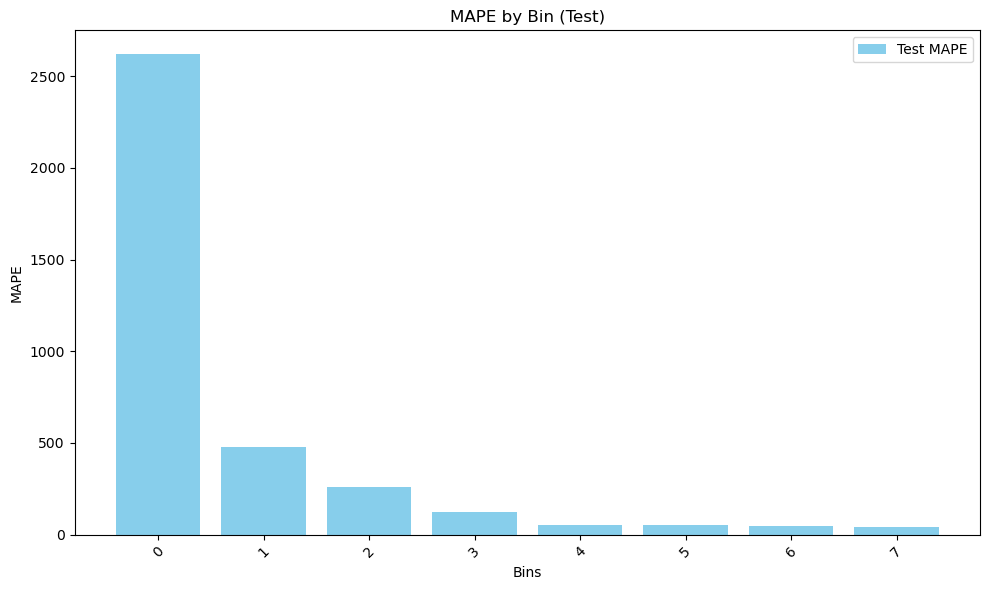

Fold 3


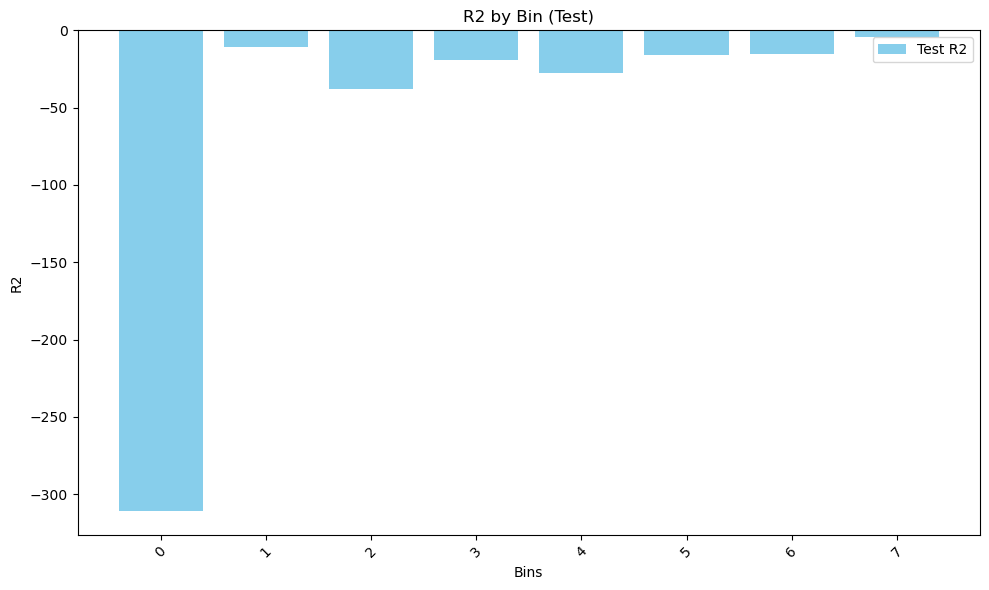

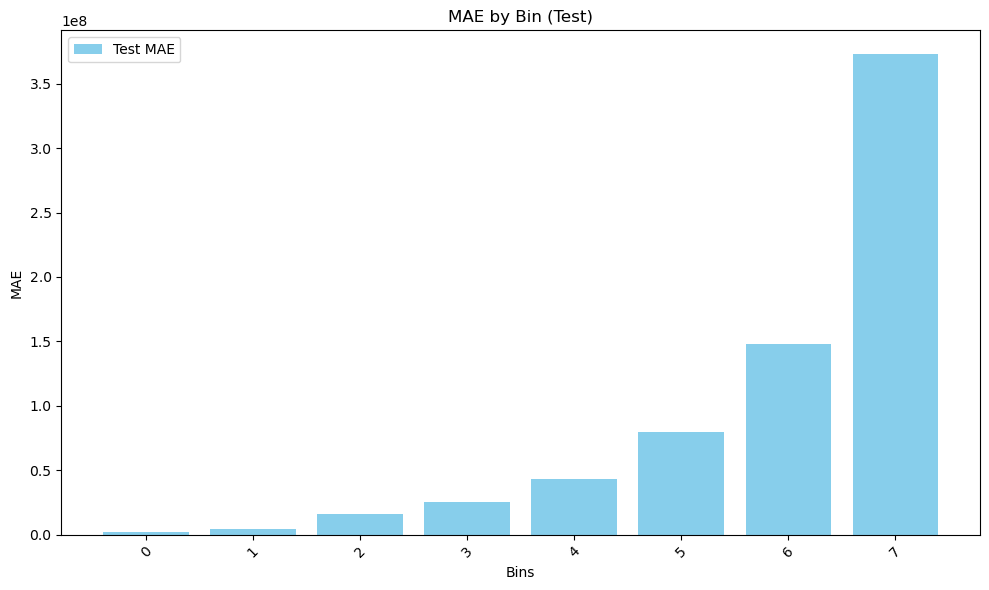

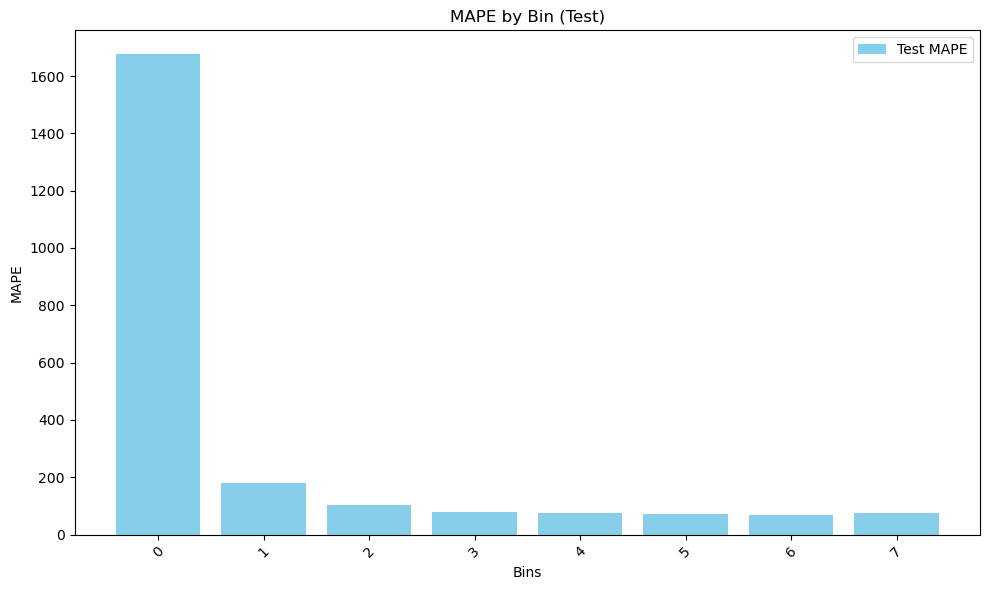

Fold 4


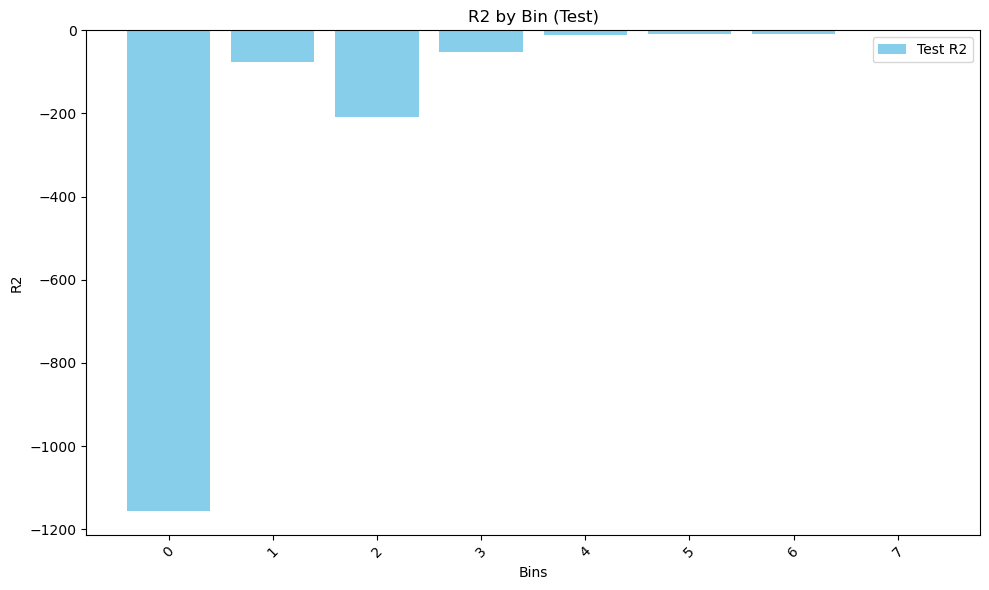

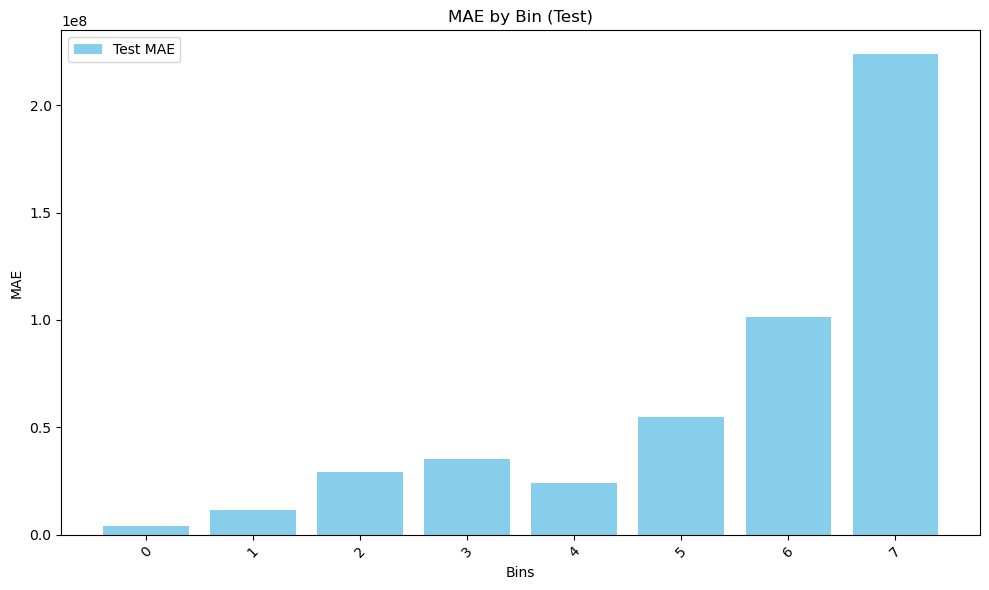

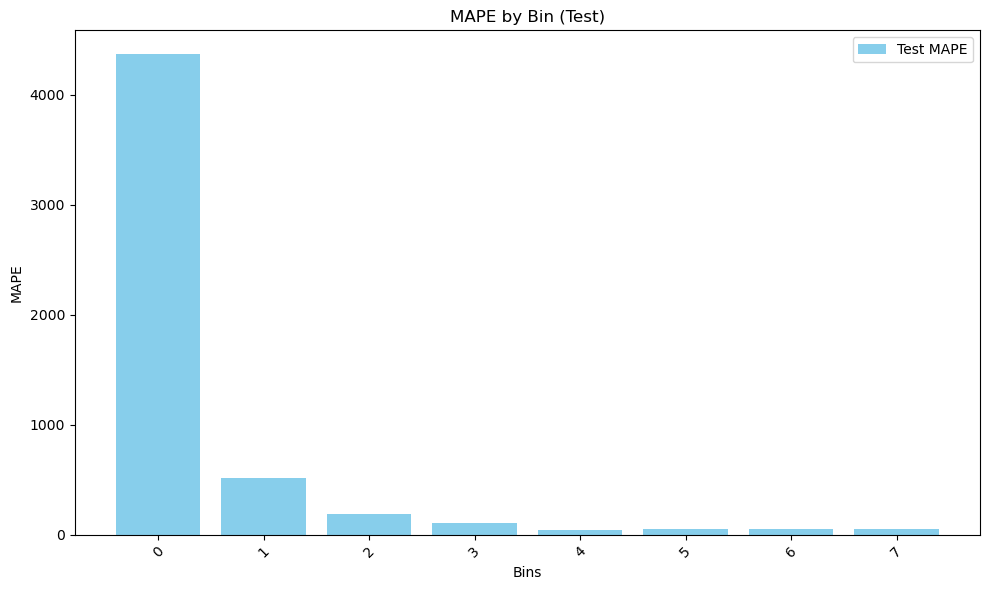

Fold 5


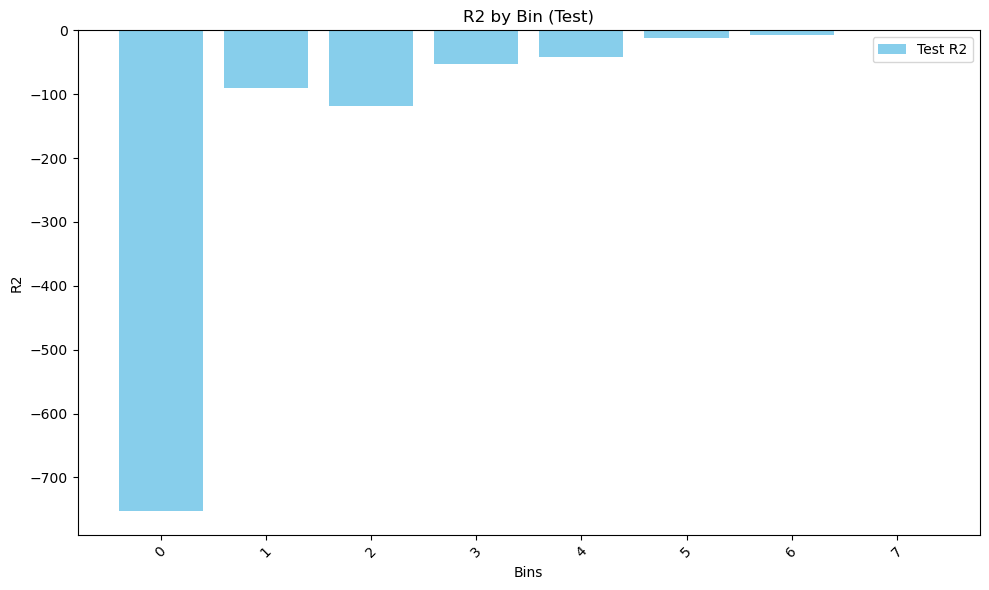

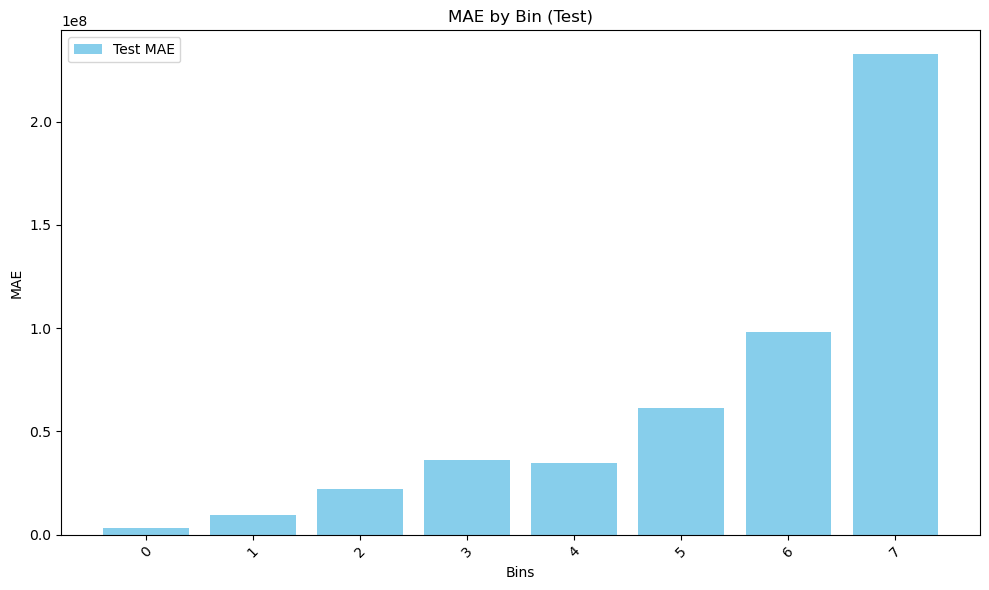

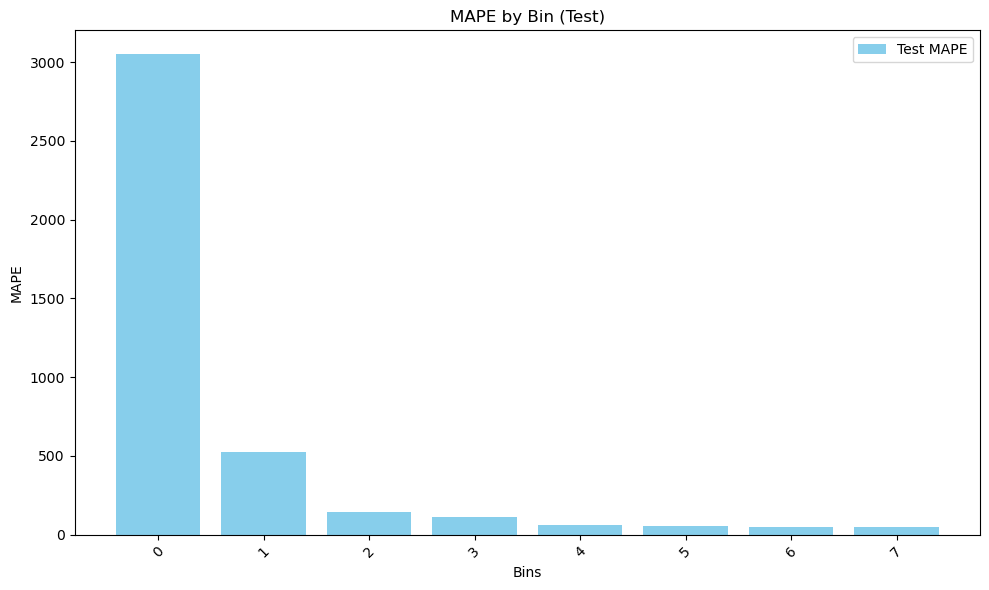

In [5]:
from settings import DEVICE
import numpy as np
from data import load_data_test
from settings import TARGET
results = []
import torch
from evaluation import _calculate_metrics
for index, model in enumerate(models):
    X_test, y_test = load_data_test(
    df=test_df,
    folder_path= model_dir,
    fold=index+1,
    target=TARGET,
    features=FEATURES
)
    # Chuyển dữ liệu về Tensor và gửi lên thiết bị (CPU/GPU)
    input_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

    # Mô hình dự đoán
    with torch.no_grad():
        pred = model(input_tensor)
        print(f"Fold {index+1}")
        test_metrics_df = visualize_results(
            df=test_df,
            y_true=y_test,
            y_pred=pred.cpu().numpy(),
            bin_column='log_gross_bin',
            calculate_real_target=True,
            dataset_label="Test"
        )
        results.append(pred.cpu().numpy())  # Chuyển về NumPy và lưu kết quả

# Tính trung bình dự đoán từ 5 mô hình
results = np.array(results)  # Chuyển danh sách sang NumPy array (shape: [5, num_samples])
average_predictions = np.mean(results, axis=0).reshape(-1)  # Trung bình trên trục 0 (5 mô hình)


In [6]:
y = test_df[TARGET].values
y.shape, average_predictions.shape


((200,), (200,))

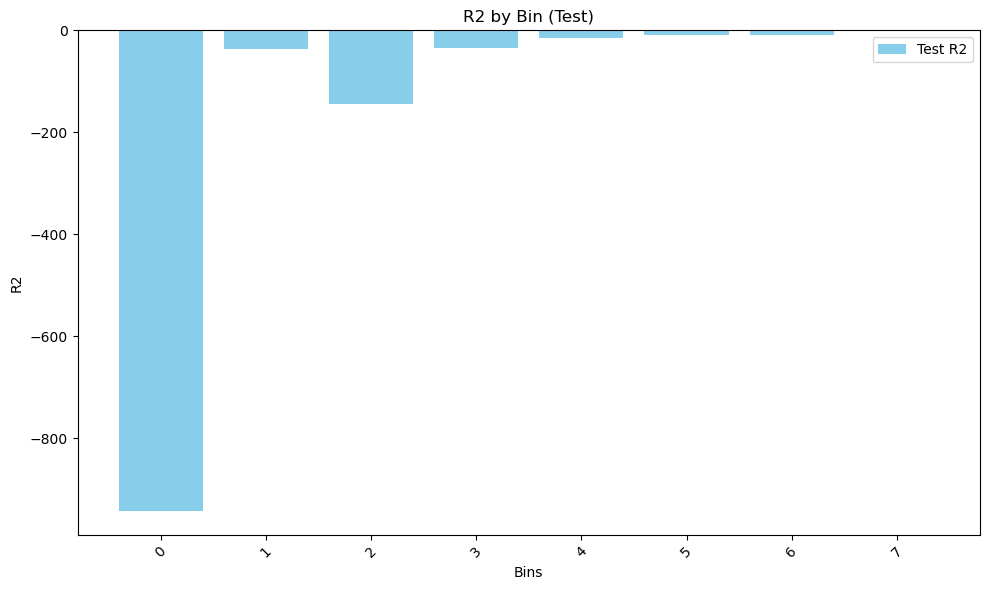

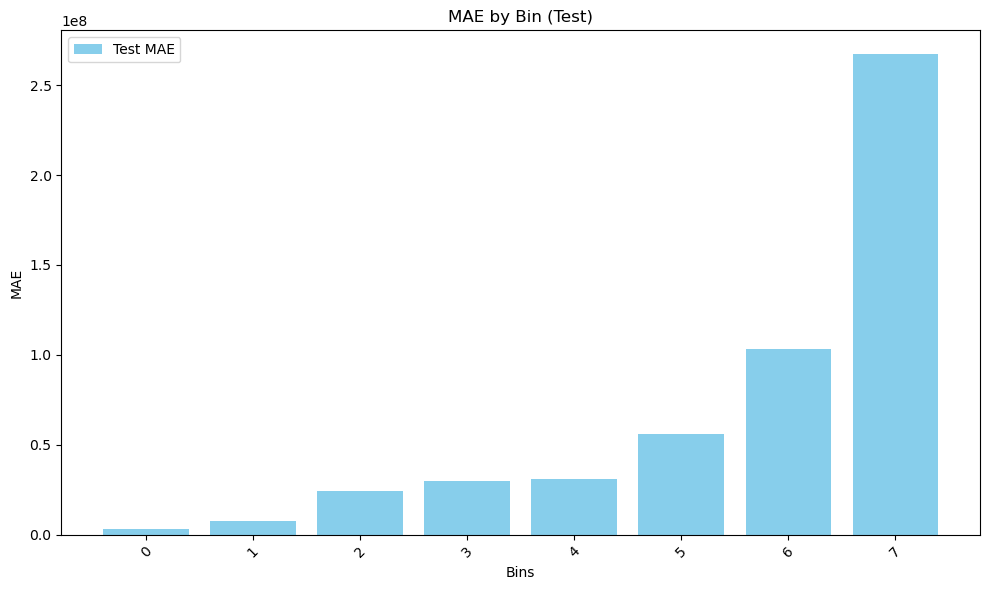

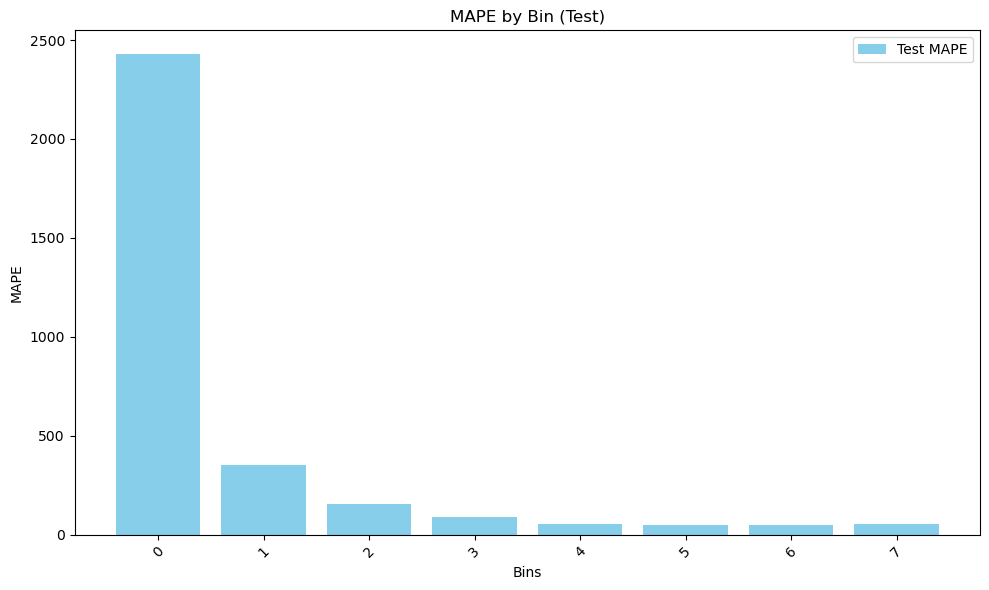

,Bin,R2,MAE,MAPE
0,0,-941.678322,3.003629e+06,2428.043591
1,1,-35.930866,7.670320e+06,351.322865
2,2,-143.626665,2.412262e+07,154.248085
3,3,-33.710881,2.992812e+07,88.472041
4,4,-15.005917,3.066340e+07,53.312797
5,5,-9.288547,5.583294e+07,49.321376
6,6,-8.784063,1.034223e+08,46.471379
7,7,-2.086682,2.671560e+08,53.591240


In [7]:
from evaluation import _calculate_metrics
visualize_results(test_df,
                  y_true=y, y_pred=average_predictions, calculate_real_target=True, dataset_label="Test")


(process:31092): Pango-WARNING **: 14:02:43.056: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:17604): Pango-WARNING **: 14:02:43.171: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:17380): Pango-WARNING **: 14:02:43.260: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


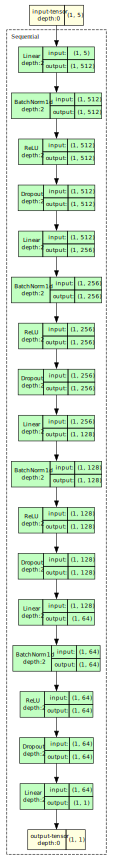

In [15]:
from torchview import draw_graph

sample_input = torch.randn(1, len(FEATURES)).to(DEVICE)  # Tạo một batch đầu vào mẫu

graph = draw_graph(
        models[0],
        input_data=sample_input,
        expand_nested=True,
        show_shapes=True,
        save_graph=True,
)

# Lưu đồ thị dưới dạng file hình ảnh
visualized_graph = graph.visual_graph.render(
    cleanup=True  # Xóa file trung gian .dot sau khi lưu ảnh
)

graph.visual_graph

In [12]:
from torchsummary import summary

# Hiển thị kiến trúc mạng
summary(models[0], input_size=(len(FEATURES),))  # Thay len(FEATURES) bằng số đặc trưng đầu vào

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       3,072
|    └─BatchNorm1d: 2-2                  1,024
|    └─ReLU: 2-3                         --
|    └─Dropout: 2-4                      --
|    └─Linear: 2-5                       131,328
|    └─BatchNorm1d: 2-6                  512
|    └─ReLU: 2-7                         --
|    └─Dropout: 2-8                      --
|    └─Linear: 2-9                       32,896
|    └─BatchNorm1d: 2-10                 256
|    └─ReLU: 2-11                        --
|    └─Dropout: 2-12                     --
|    └─Linear: 2-13                      8,256
|    └─BatchNorm1d: 2-14                 128
|    └─ReLU: 2-15                        --
|    └─Dropout: 2-16                     --
|    └─Linear: 2-17                      65
Total params: 177,537
Trainable params: 177,537
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       3,072
|    └─BatchNorm1d: 2-2                  1,024
|    └─ReLU: 2-3                         --
|    └─Dropout: 2-4                      --
|    └─Linear: 2-5                       131,328
|    └─BatchNorm1d: 2-6                  512
|    └─ReLU: 2-7                         --
|    └─Dropout: 2-8                      --
|    └─Linear: 2-9                       32,896
|    └─BatchNorm1d: 2-10                 256
|    └─ReLU: 2-11                        --
|    └─Dropout: 2-12                     --
|    └─Linear: 2-13                      8,256
|    └─BatchNorm1d: 2-14                 128
|    └─ReLU: 2-15                        --
|    └─Dropout: 2-16                     --
|    └─Linear: 2-17                      65
Total params: 177,537
Trainable params: 177,537
Non-trainable params: 0